Make a grid of stars in the corner sensors, like  https://github.com/suberlak/AOS/blob/main/AOS_DM-31532_rotation_comcam.ipynb  

Use similar code as what was used to set 1 star in the center of sensors in the AOS code (perhaps?)

In [1]:
from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.utils.Utility import getCamera
from lsst.afw.cameraGeom import DetectorType, FIELD_ANGLE
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Make a grid of stars

In [3]:
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE, FOCAL_PLANE
from lsst.geom import Point2D

def get_donut_grid(radius = 80, margin = 40,xmax = 4000, ymax = 2000):

    xmin = margin+radius
    ymin = xmin

    xlist = np.arange(xmin,xmax-margin, 2*(radius+margin))
    ylist = np.arange(ymin,ymax-margin, 2*(radius+margin))

    x_,y_ = np.meshgrid(xlist,ylist)

    xs = np.ravel(x_)
    ys = np.ravel(y_)

    return xs,ys

instName = "lsst"

# only for instName = "lsst"   
fieldX, fieldY = list(), list()
camera = getCamera(instName)
task = CloseLoopTask()

for name in task.getSensorNameListOfFields(instName):
    detector = camera.get(name)
    
    # add grid of points
    xs,ys = get_donut_grid()
    transform = detector.getTransform(PIXELS, FIELD_ANGLE)
    
    # make a list of points in pixels 
    fps = [Point2D(fpx,fpy) for fpx, fpy in zip(xs,ys)]
    
    # transform from pixels to radians 
    pixels = transform.applyForward(fps)

    # this is now in field angle coords, i.e. radians
    fpxRad = [pixel.x for pixel in pixels]
    fpyRad = [pixel.y for pixel in pixels]
    
    # radians to degrees + transpose for phoSim 
    fpyDeg = [np.rad2deg(fp) for fp in fpxRad]
    fpxDeg = [np.rad2deg(fp) for fp in fpyRad]
    
    fieldX = np.append(fieldX, fpxDeg)
    fieldY = np.append(fieldY, fpyDeg)
    
# this is enough information:  fieldX, fieldY in degrees
# to save the star catalog file 

# Save the input catalog 
from astropy.table import Table
# make an inst catalog 
coords = Table(data=[fieldX, fieldY],  names=['Ra','Decl'])

# add a column with object id 
coords['Id'] = np.arange(len(coords))
mag = 19
coords['Mag'] = mag
fname = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}.txt'
coords[['Id','Ra','Decl','Mag']].write(fname, 
                                       format='ascii.commented_header',
                                      overwrite=True)
print(f'saved as {fname}')

## Submit batch job to slurm on S3DF

Make a slurm file  `/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/runSlurm.sl`, given that we have on USDF 128 cores / node , make ~ 1 task / core :

    #!/bin/bash -l
    #SBATCH --partition roma
    #SBATCH --nodes 3
    #SBATCH --ntasks 180
    #SBATCH -t 100:00:00
    #SBATCH --job-name wfsGrid

    echo "starting at `date` on `hostname`"

    pwd

    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 180 --boresightDeg 0.0 0.0 --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid.txt --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/

    echo "ended at `date` on `hostname`"

And submit as  `sbatch runSlurm.sl` 


(later  - are there more nodes available to condor? https://sdf.slac.stanford.edu/public/doc/#/batch-compute  ) 

This runs with 

    /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/iter0/pert/starWfs.inst
    /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/iter0/pert/star.cmd
    /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/iter0/img/wfs/starWfsPhosim.log 



# Plot the resulting iter0 images from imgCloseLoop

Let's check the iter0 images and donut postage stamps, since that's what's most interesting for me 

Can select either `15` , `16`,  `17`, `18`  - these are grids of stars of different magnitudes

All same magnitude, so that the only differing thing are degrees of vignetting.



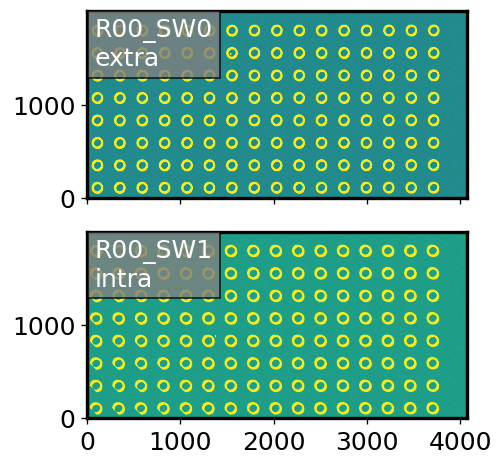

In [4]:
import centroid_functions as func 
from astropy.visualization import ZScaleInterval
# Load the stamps
mag = 17
repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
  
# choose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,
                                                             instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,
                                                             instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

intraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()


zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":

    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i=1


plt.tight_layout()
plt.show()



Code to identify donuts with hot pixels. This is done by comparing the zscale vmin/vmax to global vmin, vmax




In [5]:
def find_hot_pixels(donutStamps, threshold=3):
    
    hot_dic = {'i':[], 'vmax':[], 'gmax':[]}
    for i in range(len(donutStamps)):
        stamp = donutStamps[i]
        data = stamp.stamp_im.getImage().getArray()
        # find global min/max 
        gmin, gmax = np.min(data), np.max(data)

        # find zscale min, max
        vmin, vmax = zscale.get_limits(data)

        if gmax > threshold*vmax:
            print(i, vmax, gmax, 'potential hot pixel ')
            hot_dic['i'].append(i)
            hot_dic['vmax'].append(vmax)
            hot_dic['gmax'].append(gmax)
    if len(hot_dic['i'])==0:
        print(f'no hot pixels found where global max > {threshold} zscale vmax ')
        
    return hot_dic

In [6]:
hotExtra = find_hot_pixels(donutStampsExtra)

27 87.09021 34446.664 potential hot pixel 


In [7]:
hotIntra = find_hot_pixels(donutStampsIntra)

82 70.988754 34517.133 potential hot pixel 
97 73.98737 34498.14 potential hot pixel 


plot the intra-focal stamps, and turn off the axes since I'm just illustrating the postage stamps 

In [8]:
def plot_stamps(donutStamps, title='intra-focal', use_zscale=True):
    N = len(donutStamps)

    nrows=10
    ncols=(N // nrows)
    if N % nrows>0:
        ncols+=1
    fig,axs = plt.subplots(nrows,ncols, figsize=(20,20))
    ax = np.ravel(axs)
    i = 0 
    for stamp in donutStamps:
        data =  stamp.stamp_im.getImage().getArray()
        if use_zscale:
            vmin, vmax = zscale.get_limits(data)
            ax[i].imshow(data, vmin=vmin,vmax=vmax, origin='lower')
        else:
            ax[i].imshow(data, origin='lower')
        ax[i].text(70,80, f'{i}', fontsize=17, c='white')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i += 1 
    M = nrows*ncols
    for i in range(N,M):
        ax[i].axis('off')
    fig.text(0.46, 0.89, title, fontsize=19)

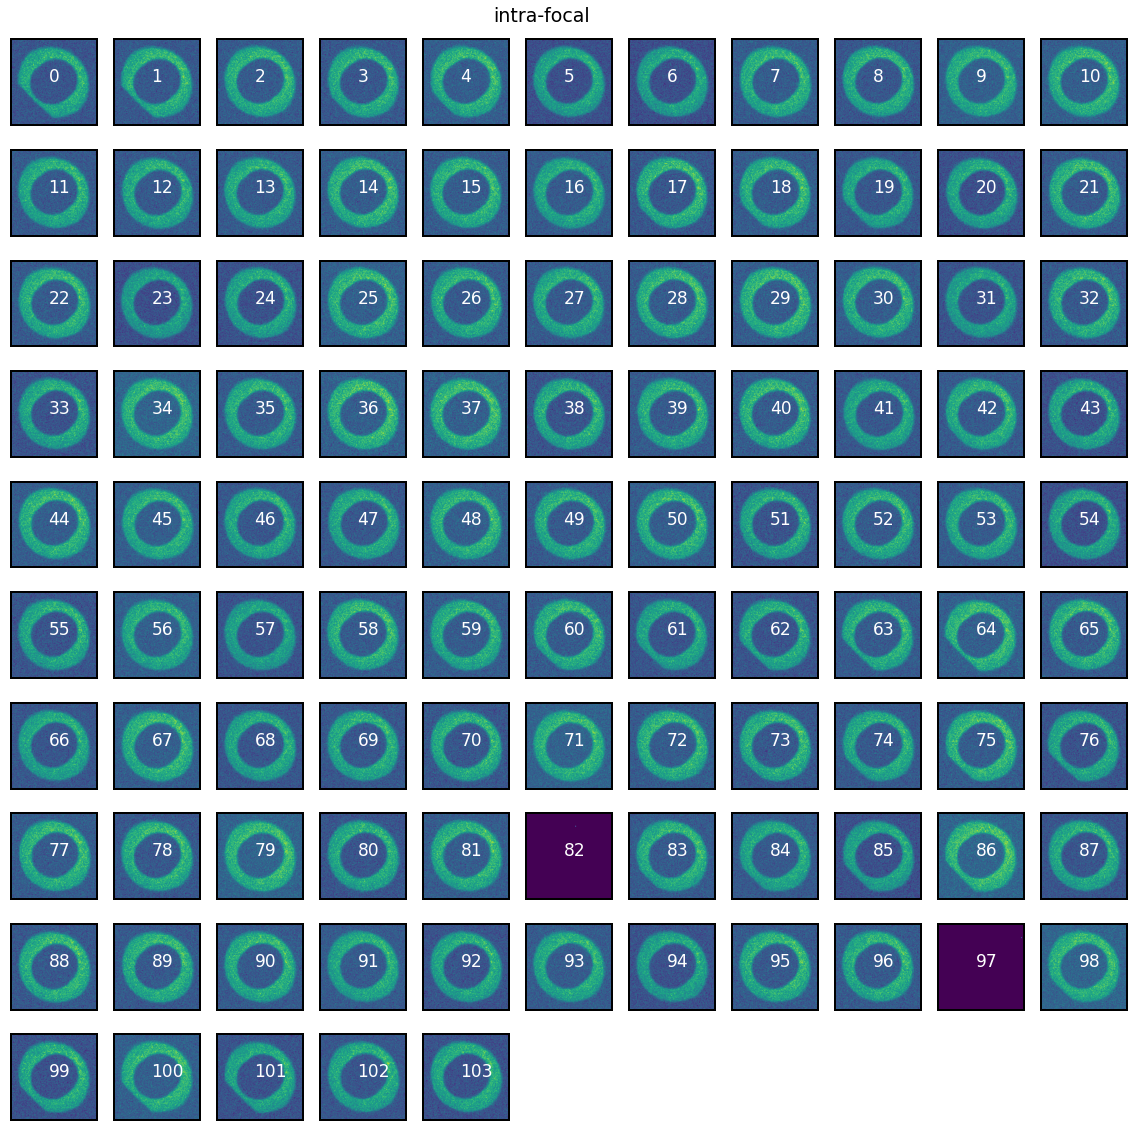

In [9]:
plot_stamps(donutStampsIntra, title='intra-focal', use_zscale=False)

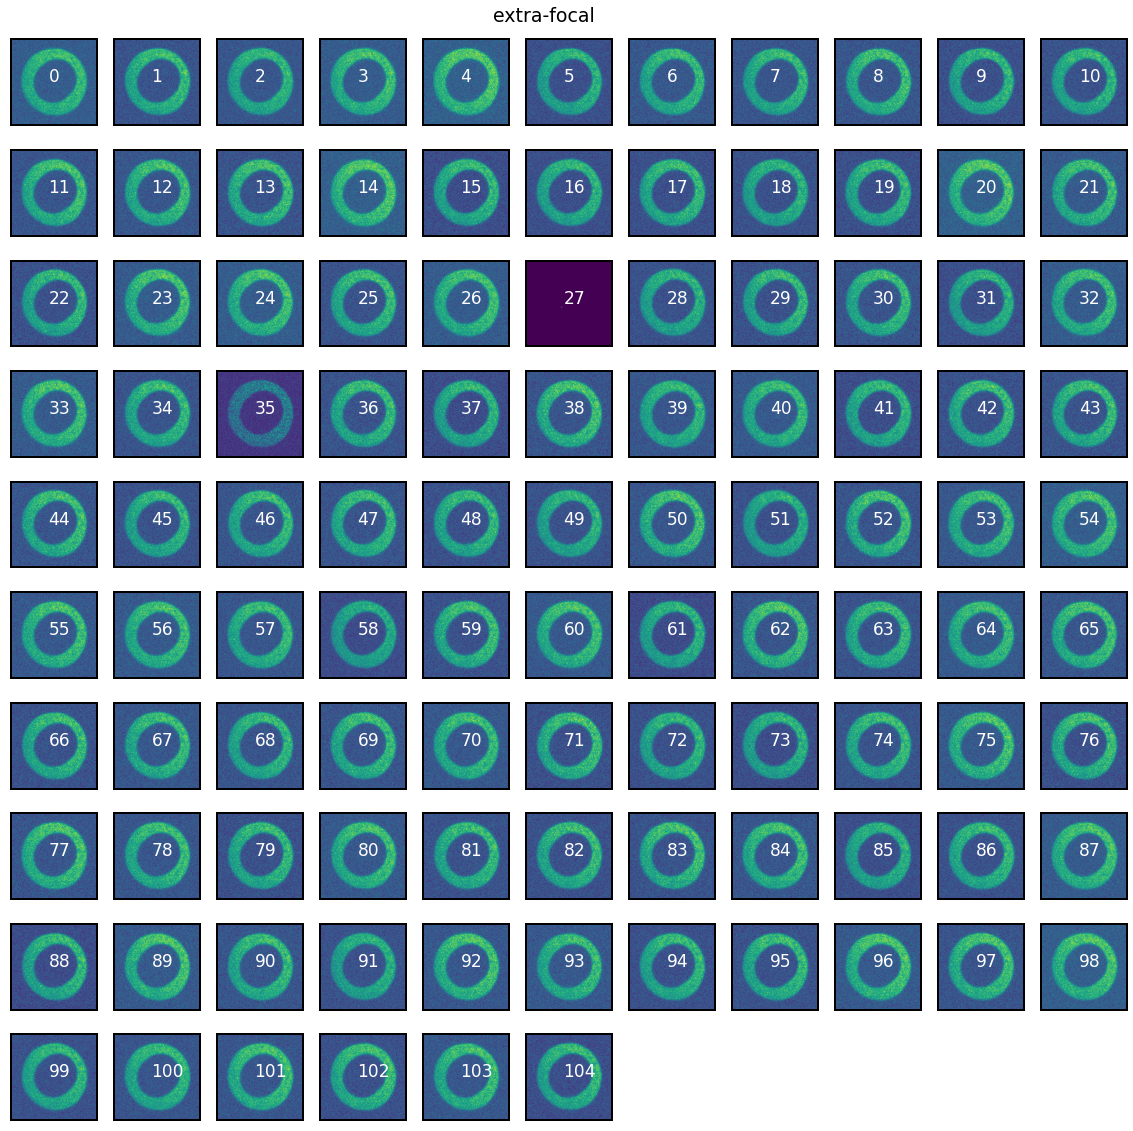

In [10]:
plot_stamps(donutStampsExtra, title='extra-focal', use_zscale=False)

For mag 15, what's going on with stamps 82 and 97 ?  They appear very dark without using `zscale`. This is because they each have very bright hot pixel that messes with `imshow` forcing a very high `vmax`. 

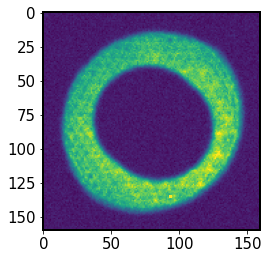

In [177]:
i=97
data = donutStampsIntra[82].stamp_im.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)

Turns out there's a hot pixel that sets artificially high limit on the stamp. Now that I've added vmin, vmax to all stamps, they look all fine. 

For mag 19, intra-focal 14th stamp is probably incorrectly centered because of hot pixel...

Would need to ignore N=14 for that magnitude



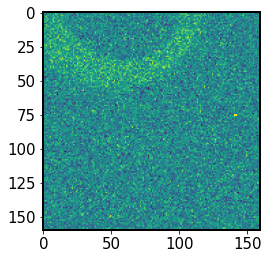

In [12]:
i=14
data = donutStampsIntra[i].stamp_im.getImage().getArray()
vmin, vmax = zscale.get_limits(data)
plt.imshow(data,vmin=vmin,vmax=vmax)

## Compare __version__ of AOS packages...
Doesn't make sense.... donuts are simulated just fine,  but none are cut out into postage stamps! 

The loop should fail in this case rather than keep going with no corrections applied whatsoever...


Let's check versions of `ts_phosim` , `ts_wep`,  `ts_ofc` , and then do `git pull` in the appropriate directory to ensure I have correct ones ...



m

In [125]:
from lsst.ts.phosim import __version__
print(__version__)

v2.0.6-7-g59bfe55


I updated it to v2.0.9 , which only changed the focusZ value to mm ... m

In [126]:
from lsst.ts.wep import __version__
__version__

'unknown'

But given `git log` I was at `40a62fd` which was Aug 15 (PR#145) ... Could this have caused this issue? 

Now I'm up-to-date with v2.7.0



In [127]:
from lsst.ts.ofc import __version__
__version__

'v2.0.1-17-g761a71a'

It was already up-to-date... BTW the tag version above does not match the `git tag` (which indicates that the latest tag is `v2.0.6`...)

Ok, `ts_phosim` has that https://github.com/lsst-ts/ts_phosim/blob/bf49b3865aaa4563948a262d8c6a40ccee63eb2e/setup.py#L35 , which generates `__version__`,  but `ts_wep` lacks `setup.py` altogether ... (do we need to add one?)

   cd /sdf/group/rubin/ncsa-home/home/scichris/aos/

# Rerun the `CloseLoopTask`, making grids of donuts with 16th, 17th, 18th, 19th mag.  

Increase the threshold in `DonutSelectorTask` .

  

Because the entire pipeline file needs to be specified,  I copy one that was created for the previous run, and modify the `magLimit` element... 

Renamed `wfs_grid` to `wfs_grid_16_old` , because that's what it is .. (16th mag stars that did not get selected...)

I copy the `pipelinefile`:

    cp wfs_grid_16_old/phosimData/lsstPipeline.yaml .
    
Modify it with `nano` increasing the magnitude limit:

    referenceSelector.magLimit.maximum: 18.5

I save it as `lsstPipelineIncreaseMagLimit.yaml` 

And run `imgCloseLoop` with the list of `17`th mag stars, `wfs_grid_17.txt`  but with that pipeline yaml file:

      python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 180 --boresightDeg 0.0 0.0 --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid.txt --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid/ --pipelineFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/lsstPipelineIncreaseMagLimit.yaml
      
I do the same with `18` mag 
